In [45]:
n_mfcc = 64
n_mfcc_width = 432
window_size = 10
audio_len = 150
data_dir = 'audio-train-new'
n_samples = 118

In [161]:
import librosa as lp
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import shutil
from scikits.talkbox import lpc


def convert_to_lpc(filename,number_of_coefficients):
    wave, sr = lp.load(filename, mono=True, sr=None)
    lpc_signal=lpc(wave,number_of_coefficients)
#     print lpc_signal[0].shape, lpc_signal[1].shape, lpc_signal[2].shape
#     print lpc_signal
#     lpcc_signal=lpcc(lpc_signal[0],lpc_signal[1])
#     print lpc_signal.shape
    return np.hstack((lpc_signal[0],lpc_signal[1],lpc_signal[2]))
                    

def lpcc(seq, err_term, order=None):
    if order is None:
        order = len(seq) - 1
    lpcc_coeffs = [np.log(err_term), -seq[0]]
    for n in xrange(2, order + 1):
        # Use order + 1 as upper bound for the last iteration
        upbound = (order + 1 if n > order else n)
        lpcc_coef = -sum(i * lpcc_coeffs[i] * seq[n - i - 1]
                         for i in xrange(1, upbound)) * 1. / upbound
        lpcc_coef -= seq[n - 1] if n <= len(seq) else 0
        lpcc_coeffs.append(lpcc_coef)
    return lpcc_coeffs


def run_preprocess(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            print(directory)
            lpcc_data = []
            npy_file = directory + '_' + 'lpcc' + '_'+ '.npy'
#             if os.path.isfile(os.path.join(subdir, directory, npy_file)):
#                 continue

            if not os.path.isdir(os.path.join(subdir, directory, "split", split)):
                subprocess.call(["./preprocess", os.path.join(subdir, directory), length, split])

            file_path = os.path.join(subdir, directory, "split", split, "wav")
            for filename in os.listdir(file_path):
                lpcc_data.append(convert_to_lpc(os.path.join(file_path, filename),49))

            if np.asarray(lpcc_data).shape[0] == 0:
                continue
            np.save(os.path.join(subdir, directory, npy_file), np.asarray(lpcc_data))
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
#             print(np.asarray(lpcc_data).shape)
        break
            


In [47]:
import shutil

def rename_npy(root, length, split):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            npy_file = directory + '_' + length + '_' + split + '.npy'
            new_npy_file = directory + '_' + 'mfcc' + '_' + str(512) + '_' + length + '_' + split + '.npy'
            if os.path.isfile(os.path.join(subdir, directory, npy_file)):
                shutil.move(os.path.join(subdir, directory, npy_file), os.path.join(subdir, directory, new_npy_file))
        break

In [106]:
def load_features(root):
    lpcc_data=[]
    lpcc_label = []
    for subdir, dirs, files in os.walk(root):
        count=0
        for directory in dirs:
            npy_file = directory + '_' + 'lpcc' + '_' + '.npy'
            if(count==0):
                lpcc_data= np.load(os.path.join(subdir, directory, npy_file))
                print lpcc_data.shape
                lpcc_label=lpcc_data.shape[0]*[directory.split('.')[0]]
            else:
                lpcc=np.load(os.path.join(subdir, directory, npy_file))
                lpcc_data=np.vstack((lpcc_data,lpcc))
                lpcc_label += lpcc.shape[0] * [directory.split('.')[0]]
            count+=1
        break
    return lpcc_data, lpcc_label

In [49]:
def cleanup_split(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.rmtree(os.path.join(subdir, directory, "split"), ignore_errors = True)
        break

In [50]:
import glob

def cleanup_merged(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*_merged*.*")):
                os.remove(f)
        break

def cleanup_npy(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            for f in glob.glob(os.path.join(subdir, directory, "*.npy")):
                os.remove(f)
        break

In [51]:
def rename_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            shutil.move(os.path.join(subdir, directory), os.path.join(subdir, directory.split("_")[0]))
        break

def remove_extra_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            name_o = directory.split(".") 
            if len(name_o) == 2 and int(name_o[1]) > 10:
                shutil.rmtree(os.path.join(subdir, directory))
        break
    
def distribute_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if len(directory.split(".")) != 1:
                continue
            for d_subdir, d_dirs, d_files in os.walk(os.path.join(root, directory)):
                for i, sample in enumerate(d_files):
                    os.makedirs(os.path.join(subdir, directory + "." + str(i + 1)))
                    shutil.move(os.path.join(subdir, directory, sample), \
                                os.path.join(subdir, directory + "." + str(i + 1), sample))
                break
        remove_extra_samples(root)
        break
        
def combine_samples(root):
    for subdir, dirs, files in os.walk(root):
        for directory in dirs:
            if not os.path.isdir(os.path.join(subdir, directory.split(".")[0])):
                os.makedirs(os.path.join(subdir, directory.split(".")[0]))
            else:
                for f in glob.glob(os.path.join(subdir, directory.split(".")[0], "*.npy")):
                    os.remove(f)
                    shutil.rmtree(os.path.join(subdir, directory.split(".")[0], "split"), ignore_errors = True)
            for d_subdir, d_dirs, d_files in os.walk(os.path.join(root, directory)):
                mp3_files = glob.glob(os.path.join(subdir, directory, "*.mp3"))
                for i, sample in enumerate(mp3_files):
                    shutil.move(os.path.join(subdir, directory, os.path.basename(sample)), \
                                os.path.join(subdir, directory.split(".")[0], os.path.basename(sample)))
                if len(directory.split(".")) != 1:
                    shutil.rmtree(os.path.join(subdir, directory))
                break
        break

In [162]:
cleanup_split(data_dir)
# cleanup_npy(data_dir)
# rename_samples(data_dir)
# distribute_samples(data_dir)
# combine_samples(data_dir)
run_preprocess(data_dir, str(audio_len), str(window_size))

adventuresbobwhite
aequanimitas
agnesgreyversion3
airplaneflyinghandbookvol3
alondonlife
ancient
aprendizdeconspirador
aristotles
artofdivinecontentment
battle-pieces
boatsoftheglencarrig
bookofgoodcounsels
briefe
britishsubject
canti
childs
company
contes
country
curlyandfloppytwistytail
de
deepwoodstocivilization
dernier
door
dubrovsky
englishgirls
esau
essayoncriticism
experiences
explorersandtravellers
food
formation
franceatwar
greybeardsatplay
gullivers
hindu
his
historietas
historymathematics
how
human
jessejames
john
journal
konekgorbunok
lark
lebenssucher
letters
lifeofcarltonparker
little
littlebrothertothebear
littlefoldedhands
littleprincess
lob
marcia
marybartonversion2
mayorofcasterbridge3
meguriai
meister
miss
modern
moral
morallettersvol1
mounties
myreminiscences
mysteries
mystical
myths
nedfranks
new
onanirishjauntingcar
origin
pennycomequicks
philosophical
plateroyyo
psychologyofpeople
religiousaffections
republicofthefuture
reynardthefox
rose
roughriders
sabotage
sac

In [164]:
# from IPython.core.debugger import set_trace
X, y = load_features(data_dir)
print X.shape
# X=np.asarray(X)
# y=np.asarray(y)
X = X.reshape(X.shape[0], 10, -1, 1)

(15, 100)
(1680, 100)


In [165]:
print X.shape

(1680, 10, 10, 1)


In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

In [167]:
print(X.shape)
print(y.shape)


(1680, 10, 10, 1)


AttributeError: 'list' object has no attribute 'shape'

In [168]:
import keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

l_enc = LabelEncoder()
l_enc.fit(y_train)
y_train_enc = l_enc.transform(y_train)
y_train_norm = np_utils.to_categorical(y_train_enc)

l_enc.fit(y_test)
y_test_enc = l_enc.transform(y_test)
y_test_norm = np_utils.to_categorical(y_test_enc)

In [169]:
# del X, y, y_train_enc, y_test_enc, y_train, y_test
# X_train = X_train
# X_test = X_test
# X_r = X_test.reshape(X_test.shape[0], 5, -1, 1)
# X_r.shape

In [177]:
print(1)
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=(10, 10, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(len(y_test_norm[0])))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
ctr = 1

1


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='mfcc_model.png', show_shapes=True)

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 24, 0, 32)         160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 0, 32)         0         
_________________________________________________________________
activation_15 (Activation)   (None, 12, 0, 32)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 12, 0, 32)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 0, 32)         4128      
_________________________________________________________________
activation_16 (Activation)   (None, 12, 0, 32)         0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 0, 32)          0         
__________

In [178]:
train_result = model.fit(np.array(X_train), y_train_norm,
          batch_size=8,
          epochs=500,
          verbose=1,
          shuffle = True,
         validation_data=(np.array(X_test), y_test_norm))

Train on 1176 samples, validate on 504 samples
Epoch 1/500
1176/1176 [==============================] - 1s 716us/step - loss: 4.7515 - acc: 0.0060 - val_loss: 4.7586 - val_acc: 0.0139
Epoch 2/500
1176/1176 [==============================] - 1s 488us/step - loss: 4.7105 - acc: 0.0119 - val_loss: 4.6773 - val_acc: 0.0119
Epoch 3/500
1176/1176 [==============================] - 1s 467us/step - loss: 4.6801 - acc: 0.0145 - val_loss: 4.6429 - val_acc: 0.0198
Epoch 4/500
1176/1176 [==============================] - 1s 465us/step - loss: 4.6490 - acc: 0.0221 - val_loss: 4.6231 - val_acc: 0.0218
Epoch 5/500
1176/1176 [==============================] - 1s 569us/step - loss: 4.6297 - acc: 0.0170 - val_loss: 4.6153 - val_acc: 0.0198
Epoch 6/500
1176/1176 [==============================] - 1s 558us/step - loss: 4.6088 - acc: 0.0187 - val_loss: 4.5928 - val_acc: 0.0159
Epoch 7/500
1176/1176 [==============================] - 1s 497us/step - loss: 4.5919 - acc: 0.0221 - val_loss: 4.5890 - val_acc: 0

1176/1176 [==============================] - 1s 477us/step - loss: 3.2582 - acc: 0.2959 - val_loss: 3.3002 - val_acc: 0.3552
Epoch 61/500
1176/1176 [==============================] - 1s 548us/step - loss: 3.1113 - acc: 0.2976 - val_loss: 3.2740 - val_acc: 0.3552
Epoch 62/500
1176/1176 [==============================] - 1s 540us/step - loss: 3.0879 - acc: 0.3223 - val_loss: 3.2412 - val_acc: 0.3571
Epoch 63/500
1176/1176 [==============================] - 1s 482us/step - loss: 3.0998 - acc: 0.3061 - val_loss: 3.2156 - val_acc: 0.3730
Epoch 64/500
1176/1176 [==============================] - 1s 489us/step - loss: 3.0739 - acc: 0.3180 - val_loss: 3.1784 - val_acc: 0.3929
Epoch 65/500
1176/1176 [==============================] - 1s 485us/step - loss: 3.0604 - acc: 0.3189 - val_loss: 3.1443 - val_acc: 0.3968
Epoch 66/500
1176/1176 [==============================] - 1s 518us/step - loss: 3.0302 - acc: 0.3265 - val_loss: 3.1182 - val_acc: 0.3968
Epoch 67/500
1176/1176 [=======================

1176/1176 [==============================] - 1s 474us/step - loss: 2.0926 - acc: 0.5468 - val_loss: 2.0190 - val_acc: 0.6508
Epoch 120/500
1176/1176 [==============================] - 1s 481us/step - loss: 2.0116 - acc: 0.5485 - val_loss: 2.0010 - val_acc: 0.6548
Epoch 121/500
1176/1176 [==============================] - 1s 477us/step - loss: 1.9597 - acc: 0.5612 - val_loss: 1.9828 - val_acc: 0.6647
Epoch 122/500
1176/1176 [==============================] - 1s 476us/step - loss: 1.9573 - acc: 0.5655 - val_loss: 1.9828 - val_acc: 0.6627
Epoch 123/500
1176/1176 [==============================] - 1s 493us/step - loss: 1.9633 - acc: 0.5697 - val_loss: 2.0168 - val_acc: 0.6567
Epoch 124/500
1176/1176 [==============================] - 1s 464us/step - loss: 1.9302 - acc: 0.5527 - val_loss: 2.0046 - val_acc: 0.6587
Epoch 125/500
1176/1176 [==============================] - 1s 457us/step - loss: 1.9218 - acc: 0.5621 - val_loss: 1.9640 - val_acc: 0.6647
Epoch 126/500
1176/1176 [================

1176/1176 [==============================] - 1s 478us/step - loss: 1.4505 - acc: 0.6735 - val_loss: 1.4428 - val_acc: 0.7460
Epoch 179/500
1176/1176 [==============================] - 1s 470us/step - loss: 1.4466 - acc: 0.6854 - val_loss: 1.4348 - val_acc: 0.7361
Epoch 180/500
1176/1176 [==============================] - 1s 475us/step - loss: 1.4342 - acc: 0.6879 - val_loss: 1.4134 - val_acc: 0.7421
Epoch 181/500
1176/1176 [==============================] - 1s 480us/step - loss: 1.4008 - acc: 0.6871 - val_loss: 1.4538 - val_acc: 0.7302
Epoch 182/500
1176/1176 [==============================] - 1s 473us/step - loss: 1.3794 - acc: 0.7007 - val_loss: 1.4459 - val_acc: 0.7401
Epoch 183/500
1176/1176 [==============================] - 1s 472us/step - loss: 1.3879 - acc: 0.6871 - val_loss: 1.4358 - val_acc: 0.7421
Epoch 184/500
1176/1176 [==============================] - 1s 475us/step - loss: 1.3672 - acc: 0.7058 - val_loss: 1.4249 - val_acc: 0.7401
Epoch 185/500
1176/1176 [================

1176/1176 [==============================] - 1s 476us/step - loss: 1.0839 - acc: 0.7653 - val_loss: 1.1142 - val_acc: 0.8135
Epoch 238/500
1176/1176 [==============================] - 1s 469us/step - loss: 1.1243 - acc: 0.7500 - val_loss: 1.0937 - val_acc: 0.8175
Epoch 239/500
1176/1176 [==============================] - 1s 465us/step - loss: 1.0826 - acc: 0.7636 - val_loss: 1.0987 - val_acc: 0.8056
Epoch 240/500
1176/1176 [==============================] - 1s 469us/step - loss: 1.1305 - acc: 0.7483 - val_loss: 1.1256 - val_acc: 0.8075
Epoch 241/500
1176/1176 [==============================] - 1s 480us/step - loss: 1.1524 - acc: 0.7636 - val_loss: 1.0990 - val_acc: 0.8095
Epoch 242/500
1176/1176 [==============================] - 1s 611us/step - loss: 1.0428 - acc: 0.7823 - val_loss: 1.0924 - val_acc: 0.8115
Epoch 243/500
1176/1176 [==============================] - 1s 502us/step - loss: 1.1385 - acc: 0.7551 - val_loss: 1.0576 - val_acc: 0.8175
Epoch 244/500
1176/1176 [================

1176/1176 [==============================] - 1s 477us/step - loss: 0.9329 - acc: 0.8027 - val_loss: 0.9294 - val_acc: 0.8492
Epoch 297/500
1176/1176 [==============================] - 1s 477us/step - loss: 0.8960 - acc: 0.7968 - val_loss: 0.9436 - val_acc: 0.8472
Epoch 298/500
1176/1176 [==============================] - 1s 482us/step - loss: 0.9257 - acc: 0.8036 - val_loss: 0.9430 - val_acc: 0.8472
Epoch 299/500
1176/1176 [==============================] - 1s 474us/step - loss: 0.9173 - acc: 0.8044 - val_loss: 0.9310 - val_acc: 0.8452
Epoch 300/500
1176/1176 [==============================] - 1s 466us/step - loss: 0.9235 - acc: 0.8078 - val_loss: 0.9766 - val_acc: 0.8512
Epoch 301/500
1176/1176 [==============================] - 1s 465us/step - loss: 0.9175 - acc: 0.8155 - val_loss: 0.9520 - val_acc: 0.8512
Epoch 302/500
1176/1176 [==============================] - 1s 477us/step - loss: 0.9299 - acc: 0.8180 - val_loss: 0.9230 - val_acc: 0.8512
Epoch 303/500
1176/1176 [================

1176/1176 [==============================] - 1s 479us/step - loss: 0.8428 - acc: 0.8350 - val_loss: 0.8963 - val_acc: 0.8611
Epoch 356/500
1176/1176 [==============================] - 1s 475us/step - loss: 0.8294 - acc: 0.8342 - val_loss: 0.8862 - val_acc: 0.8591
Epoch 357/500
1176/1176 [==============================] - 1s 474us/step - loss: 0.8250 - acc: 0.8308 - val_loss: 0.8711 - val_acc: 0.8651
Epoch 358/500
1176/1176 [==============================] - 1s 482us/step - loss: 0.8162 - acc: 0.8206 - val_loss: 0.8646 - val_acc: 0.8710
Epoch 359/500
1176/1176 [==============================] - 1s 478us/step - loss: 0.8546 - acc: 0.8308 - val_loss: 0.8686 - val_acc: 0.8730
Epoch 360/500
1176/1176 [==============================] - 1s 484us/step - loss: 0.8982 - acc: 0.8418 - val_loss: 0.9076 - val_acc: 0.8591
Epoch 361/500
1176/1176 [==============================] - 1s 479us/step - loss: 0.7820 - acc: 0.8418 - val_loss: 0.9037 - val_acc: 0.8651
Epoch 362/500
1176/1176 [================

Epoch 414/500
1176/1176 [==============================] - 1s 528us/step - loss: 0.7768 - acc: 0.8537 - val_loss: 0.7752 - val_acc: 0.8710
Epoch 415/500
1176/1176 [==============================] - 1s 567us/step - loss: 0.7327 - acc: 0.8444 - val_loss: 0.8168 - val_acc: 0.8690
Epoch 416/500
1176/1176 [==============================] - 1s 486us/step - loss: 0.7492 - acc: 0.8571 - val_loss: 0.7881 - val_acc: 0.8750
Epoch 417/500
1176/1176 [==============================] - 1s 492us/step - loss: 0.7628 - acc: 0.8418 - val_loss: 0.8057 - val_acc: 0.8710
Epoch 418/500
1176/1176 [==============================] - 1s 499us/step - loss: 0.7834 - acc: 0.8393 - val_loss: 0.8088 - val_acc: 0.8770
Epoch 419/500
1176/1176 [==============================] - 1s 510us/step - loss: 0.7469 - acc: 0.8656 - val_loss: 0.7878 - val_acc: 0.8770
Epoch 420/500
1176/1176 [==============================] - 1s 514us/step - loss: 0.8735 - acc: 0.8376 - val_loss: 0.7938 - val_acc: 0.8829
Epoch 421/500
1176/1176 [==

Epoch 473/500
1176/1176 [==============================] - 1s 457us/step - loss: 0.6354 - acc: 0.8801 - val_loss: 0.7699 - val_acc: 0.8849
Epoch 474/500
1176/1176 [==============================] - 1s 443us/step - loss: 0.6929 - acc: 0.8648 - val_loss: 0.7822 - val_acc: 0.8750
Epoch 475/500
1176/1176 [==============================] - 1s 442us/step - loss: 0.6684 - acc: 0.8724 - val_loss: 0.7848 - val_acc: 0.8750
Epoch 476/500
1176/1176 [==============================] - 1s 472us/step - loss: 0.6340 - acc: 0.8665 - val_loss: 0.7839 - val_acc: 0.8730
Epoch 477/500
1176/1176 [==============================] - 1s 484us/step - loss: 0.6224 - acc: 0.8937 - val_loss: 0.7780 - val_acc: 0.8770
Epoch 478/500
1176/1176 [==============================] - 1s 524us/step - loss: 0.5931 - acc: 0.8801 - val_loss: 0.7840 - val_acc: 0.8790
Epoch 479/500
1176/1176 [==============================] - 1s 634us/step - loss: 0.6739 - acc: 0.8707 - val_loss: 0.7462 - val_acc: 0.8750
Epoch 480/500
1176/1176 [==

In [175]:
model.save_weights('lpc_model_weights_' + str(audio_len) + '_' + str(window_size) + '-' + str(ctr) + '.h5')
ctr += 1

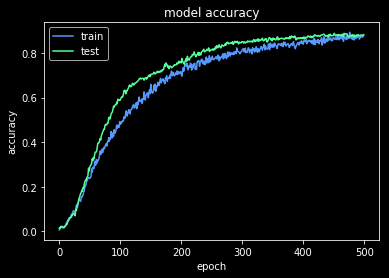

In [179]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.plot(train_result.history['acc'], color="#5599FF")
plt.plot(train_result.history['val_acc'], color="#55FF99")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()